# Stroke Prediction Classification


### **Introduction:**

The 5th highest cause of death and the leading cause of disability in the United States is due in part to strokes (Cerebrovascular Accidents). Strokes are the result of an insufficient supply of oxygen and nutrients to the brain due to a blood vessel bursting. Subsequently, brain cells die, which can often cause right-sided weakness/paralysis, and sensory impairment.

This prediction classification project will answer the question of whether or not someone is likely to experience a stroke based on 8 different core factors relating to health and demographic.

The “Stroke Prediction Dataset”, acquired from kaggle.com, contains 12 columns, including different factors that may affect someone’s likelihood of experiencing a stroke, as well as whether or not the patient experienced a stroke, and other patient information.

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### **Preliminary Exploratory Data Analysis:**

Although not all values are used, we must ensure that we properly tidy the data into a usable format. Tidy data entails:
* Each row has a single observation.
* Each column has a single variable.
* Each value is in a single cell.

The data included almost all these components, except for N/A values in the bmi column of the data set. However, the missing values must be counted later on once the data is split into the training set. Consequently, the missing vales will remain in the data set until a little bit later.

Changing each variable to its correct type can be beneficial (even if it is not used), since it will help with usability later on if needed. This can be done before the data is split into the training and testing set.

In [10]:
url <- "https://raw.githubusercontent.com/romansinkus/DS_Group_Project/main/healthcare-dataset-stroke-data.csv"
untidy_stroke_data <- read_csv(url)
stroke_data <- untidy_stroke_data %>%
    select(-id) %>% 
    mutate(bmi = as.numeric(bmi)) %>% 
    rename(residence_type = Residence_type) %>% 
    mutate(across(c(gender, hypertension:residence_type, smoking_status:stroke), as_factor))

stroke_data

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
Female,61,0,0,Yes,Self-employed,Rural,202.21,NA,never smoked,1
Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


Now that the data has been optimized for usability (but not completely tidied), it can be split into the training data and testing day (75% will be allocated as training data).

In [11]:
stroke_split <- initial_split(stroke_data, prop = 0.75, strata = stroke)
untidy_stroke_train <- training(stroke_split)
untidy_stroke_test <- testing(stroke_split)

Below is a table summarizing the three different categorical variables that are possible predictors for the model. The mean values have been calculated for each predictor variable.

In [12]:
avg_values <- untidy_stroke_train %>% 
    summarize(age_avg = mean(age, na.rm = TRUE),
            avg_glucose_level_avg = mean(avg_glucose_level, na.rm = TRUE),
            bmi_avg = mean(bmi, na.rm = TRUE))
avg_values

age_avg,avg_glucose_level_avg,bmi_avg
<dbl>,<dbl>,<dbl>
43.16956,106.8747,28.88532


Based on the summarization of the training data, most people indicated they were middle-aged, and had healthy average glucose levels (this range is typically from 90-110 mg/dL). The average patient observed exhibited a body mass index indicating they were in the "overweight" category (25.0—29.9).

The metadata (information about how data was collected) indicated that there were some missing values for the bmi column of the data set. Below is a table that shows the number of rows (observations that include missing values).

In [16]:
missing_bmi <- untidy_stroke_train %>%
    select(bmi) %>%
    count(is.na(bmi))
missing_bmi

is.na(bmi),n
<lgl>,<int>
FALSE,3679
TRUE,154


The stroke variable is the target variable for this model. Below is a table containing the number of patients who indicated they had experienced a stroke (1 = yes, 0 = no).

In [17]:
categorical_values <- untidy_stroke_train %>%
    group_by(stroke) %>% 
    summarize(n = n())

categorical_values

`summarise()` ungrouping output (override with `.groups` argument)



stroke,n
<fct>,<int>
0,3640
1,193


Now that the missing values have been counted and displayed, they can be removed to make the data tidy (each value must be in a single cell).

In [18]:
stroke_train <- untidy_stroke_train %>% 
    filter(!is.na(bmi))

stroke_test <- untidy_stroke_test %>% 
    filter(!is.na(bmi))

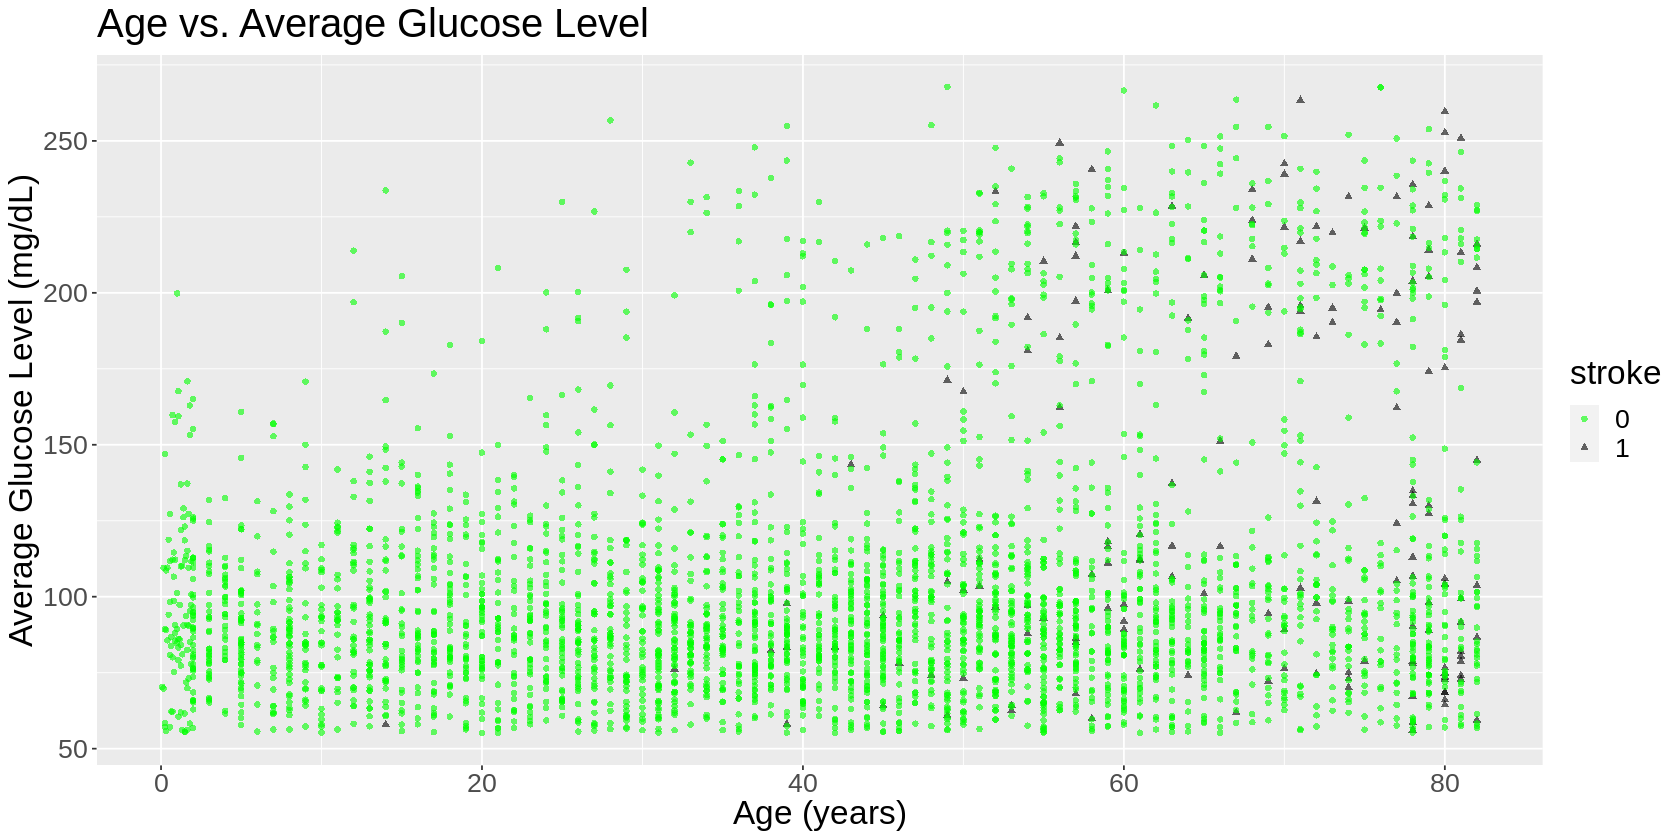

In [30]:
options(repr.plot.width = 14, repr.plot.height = 7)

age_vs_avg_glucose_level_plot <- stroke_train %>% 
    ggplot(aes(x = age, y = avg_glucose_level))+
    geom_point(aes(color = stroke, shape = stroke), alpha = 0.6)+
    labs(x = "Age (years)", y = "Average Glucose Level (mg/dL)", fill = "Stroke")+
    ggtitle("Age vs. Average Glucose Level")+
    theme(text = element_text(size = 20))+
    #scale_fill_brewer(palette = "Set2")
    scale_colour_manual(values = c("green", "black"))

age_vs_avg_glucose_level_plot

The plot indicated that there was a positive correlation between age and stroke, hence older patients would more likely suffer from a stroke, but average glucose level was not much of a factor since the patients that had a stroke are distributed almost evenly between high and low glucose levels

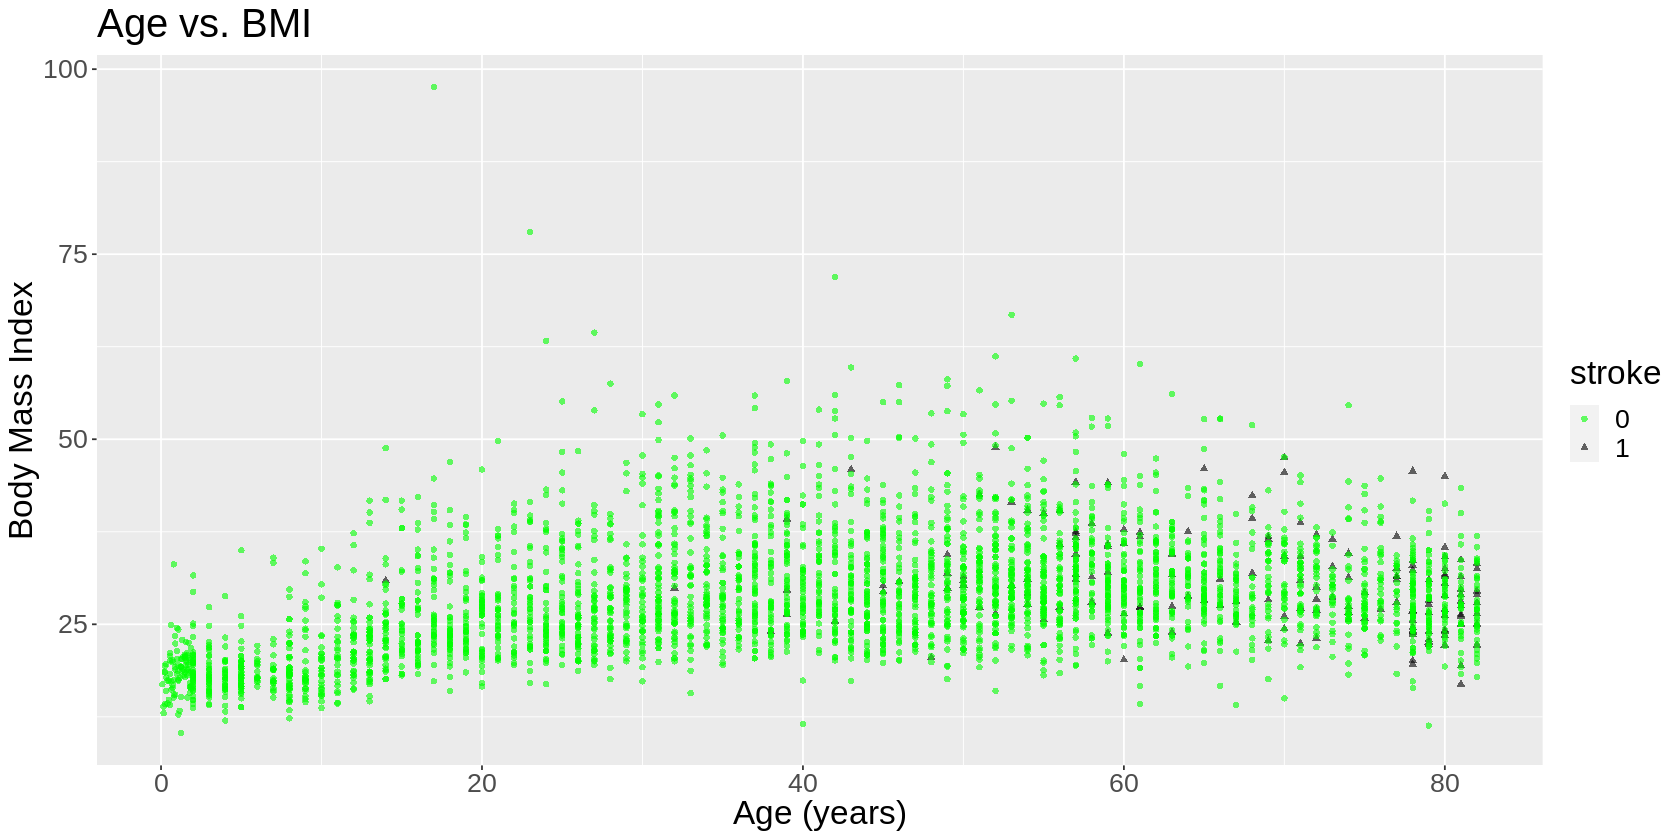

In [28]:
options(repr.plot.width = 14, repr.plot.height = 7)

age_vs_bmi_plot <- stroke_train %>% 
    ggplot(aes(x = age, y = bmi))+
    geom_point(aes(color = stroke, shape = stroke), alpha = 0.6)+
    labs(x = "Age (years)", y = "Body Mass Index", fill = "Stroke")+
    ggtitle("Age vs. BMI")+
    theme(text = element_text(size = 20))+
    scale_colour_manual(values = c("green", "black"))

age_vs_bmi_plot

The plot shows that patients that suffered strokes were of moderately higher bmi, particulalry higher than bmi of 25, and the same positive relationship with age, with higher age, more chances of strokes. 

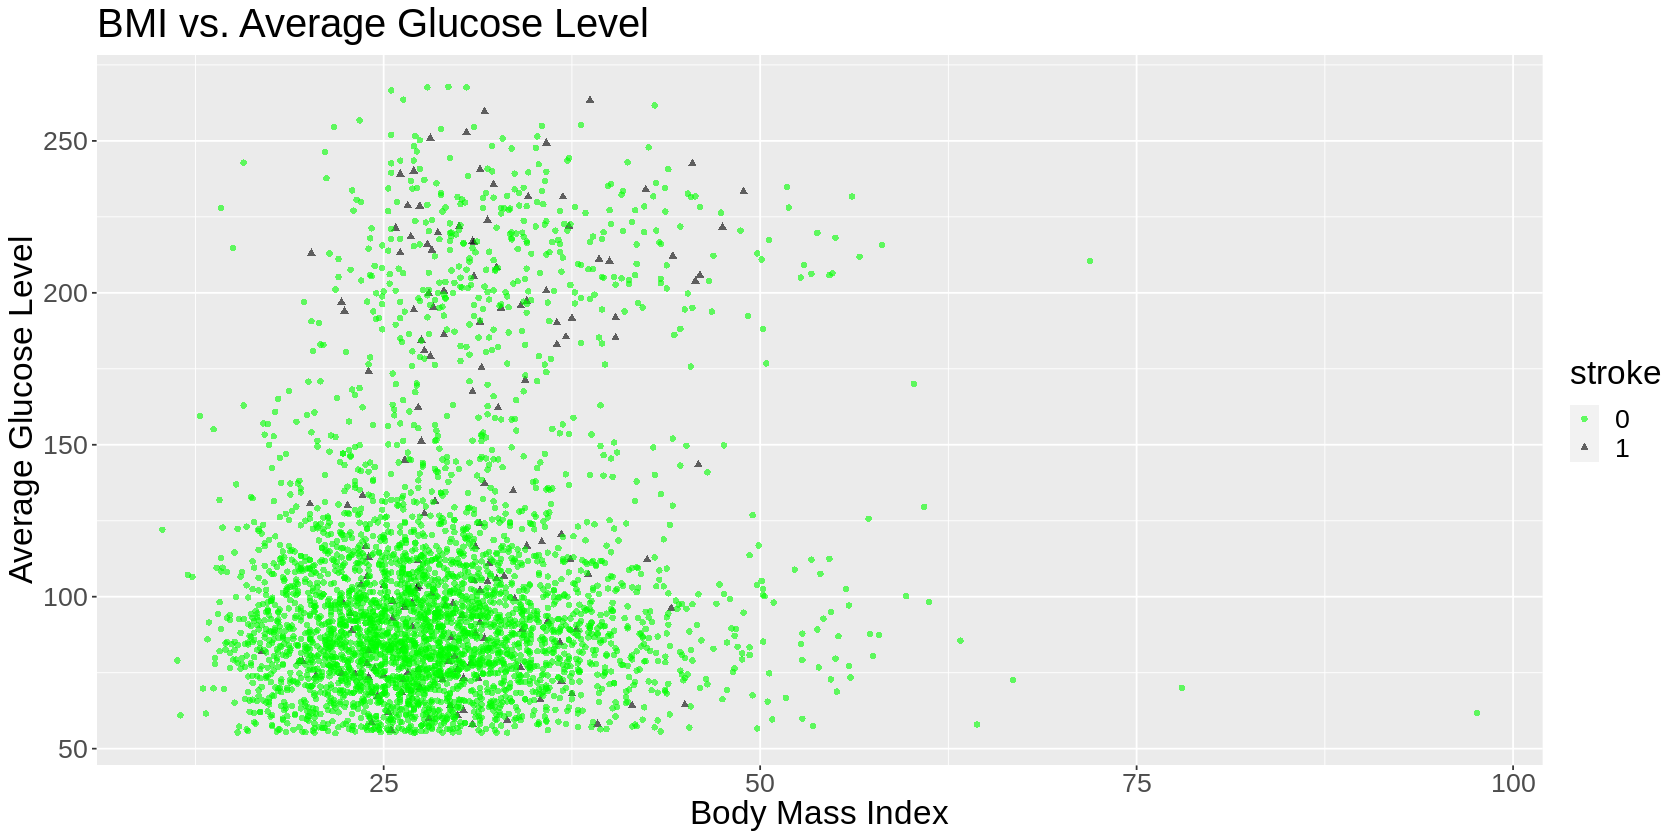

In [29]:
bmi_vs_avg_glucose_level_plot <- stroke_train %>% 
    ggplot(aes(x = bmi, y = avg_glucose_level))+
    geom_point(aes(color = stroke, shape = stroke), alpha = 0.6)+
    labs(x = "Body Mass Index", y = "Average Glucose Level", fill = "Stroke")+
    ggtitle("BMI vs. Average Glucose Level")+
    theme(text = element_text(size = 20))+
    scale_colour_manual(values = c("green", "black"))

bmi_vs_avg_glucose_level_plot

This plot shows that the average bmi of people suffering from a stroke was concentrated in between 25 and 40 the most, however, average glucose level is not much of a factor because there were patients with both lower and higher glucose level that suffered from a stroke. 

### **Methods:**

For our data analysis, we created 3 plots to see the relationship between BMI, age and average glucose level of the patient to see which factors contribute most to strokes. We considered these 3 numerical variables in the dataset, because these are the ones that are going to help us predict our class using the kknn classification model. After observing all the plots, we concluded that we would only be using 2 variables that had a visible relationship to strokes and these were bmi and age because average glucose level did not have a clear positive relationship with having a stroke.  

After creating a summary table analyzing the number of people that suffered from a stroke, we found out there was class imbalance as the number of people who had a stroke was 193, and the number who didn’t was 3640, this can lead to bias with the classifier. To solve this problem, when doing the classification model, we will rebalance the data by oversampling the stroke = 1 case to give it more voting power leading to a more accurate prediction.

To predict the testing set, we will use cross-validation to split our training data. Then, we will create a recipe that specifies the class label and our 2 predictors (bmi and age). Then create nearest_neighbor model specification to choose the k with the highest accuracy. Consequently, we add the model and recipe to a workflow and pick a suitable k value. We would then put this value into the predict function and calculate the accuracy to see if the testing set was predicted accurately.


### **Expected Outcomes and Significance:**

We expect to find a trend that can help determine if a patient is more likely to suffer from a stroke. This depends on several factors in question, based on a patient’s health or living habits or demographics. For example, being overweight or having a higher bmi, would mean the patient is more likely to suffer from a stroke. Also, patients of older age would be of higher risk of having a stroke than younger ones. 

Using this prediction, predicting a stroke would be an easier and more efficient process. It could help many patients seek help at an early stage, to prevent serious outcomes from occurring. Knowing these factors would help doctors to early diagnose stroke by asking the right questions to the patients and doing the right tests such as measuring blood glucose levels. Additionally, Knowing the factors that can lead to an individual suffering from stroke may influence their life decisions such as eating habits, where to live, or whether to quit smoking. 

**Future Questions:**